In [1]:
import os
import json
import glob
import shutil
from math import dist
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.font_manager import FontProperties
from _info_ import ear_types, degrees, acupoints_name, cm
from _common_ import angles
from typing import Union


In [2]:
class errors():
    def __init__(self, path_folder):
        self.path_folder = path_folder
        self.warp_result = None
        
    def read_error_csv(self, fpath1):
        error_np = pd.read_csv(fpath1, index_col = 0).to_numpy()
        return error_np

    def wrap_err_from_csv(self):
        result = {}
        for ear_type in ear_types:
            result[ear_type] = []
            names = os.listdir(os.path.join("..", self.path_folder, ear_type, "result"))
            for name in names:
                deg_err = []
                for deg in degrees:
                    angles_err = []
                    
                    csv_pth = os.path.join("..", self.path_folder, ear_type, "result", name, "error", deg, "error.csv")
                    error_np = self.read_error_csv(csv_pth)
                    indexes = angles(error_np, 4)
                    
                    for index in indexes:
                        angles_err.append(error_np[index])
                    deg_err.append(angles_err)
                result[ear_type].append(deg_err)             #shape = (subjects, degrees, angles, acupoints)           
        return result     

In [3]:
class plot_fig():
    def __init__(self, errors: Union[dict, list]):
        self.wrapped_errors = errors
#         print(np.array(errors[0]["free"]).shape)
        
    def unwrapped_to_CDF(self, wrapped_errors_dict):
        CDF = {}
        for ear_type in ear_types:
            CDF[ear_type]= {}
            total = np.array(wrapped_errors_dict[ear_type])
            total = total.reshape(-1)
            
            sorted_error = np.sort(total*10)
            cumulative_prob = np.arange(1, len(total) + 1) / len(total)
            
            CDF[ear_type]["sorted_error"] = sorted_error
            CDF[ear_type]["cumulative_prob"] = cumulative_prob
            
        return CDF
    def CDF_fig(self, title, label):
        if isinstance(self.wrapped_errors, dict):
            CDF = self.unwrapped_to_CDF(self.wrapped_errors)
            for ear_type in ear_types: 

                plt.plot(CDF[ear_type]["sorted_error"], CDF[ear_type]["cumulative_prob"], label = label)
                plt.xlim(0, 10)
                plt.ylim(0, 1.1)
                plt.xlabel("mm")
                plt.ylabel("Probability")
                plt.title(title)
                plt.legend()
                plt.show()
        elif isinstance(self.wrapped_errors, list):
            for ear_type in ear_types:
                for i in range(0, len(self.wrapped_errors)):
                    CDF = self.unwrapped_to_CDF(self.wrapped_errors[i])
                    plt.plot(CDF[ear_type]["sorted_error"], CDF[ear_type]["cumulative_prob"], label = label[i])
                plt.xlim(0, 10)
                plt.ylim(0, 1.1)
                plt.xlabel("mm")
                plt.ylabel("Probability")
                plt.title(title)
                plt.legend()
                plt.show()

        else:
            raise ValueError("Unsupported type")
    def bar_fig(self, label, plot_type = "acupoints"):
        
        if isinstance(self.wrapped_errors, dict):
            if plot_type == "acupoints":
                permute_dim = (1, 2, 3, 0)
                title = "Acupoint localization error"
            else:
                permute_dim = (1, 2, 0, 3)
                title = "Acupoint localization error on different subjects"
            for ear_type in ear_types:
                x = np.transpose(self.wrapped_errors[ear_type], permute_dim)*10
                means = np.nanmean(x, axis = 3)
                stds = np.nanstd(x, axis = 3)
                if plot_type == "acupoints":
                    tick_label = acupoints_name[:x.shape[2]]
                else:
                    tick_label = ["Subject"+str(x) for x in list(range(0 , x.shape[2]))]
                
                for i in range(0, len(x)):
                    plt.figure(figsize=(15,10))
                    for j in range(0 ,len(x[0])):

                        plt.bar(np.arange(x.shape[2]) + j*0.2, means[i][j], yerr=stds[i][j], align='center', label = '{index} degrees'.format(index = 0 + 10*j), ecolor='black', capsize=3, width=0.2)

                    plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

                    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

                    font_path = r'C:\Windows\Fonts\msjhl.ttc'
                    font = FontProperties(fname=font_path, size=12)
                    
                    plt.xticks(np.arange(x.shape[2]) + 0.3, tick_label, fontsize=12, rotation=-45, ha='center')
         
                    plt.yticks(fontsize=30)
                    plt.title(title, fontsize = 30, pad = 20)

                    plt.legend(fontsize=17, ncol = 1, loc = (1.001,0))

                    plt.tight_layout()

                    if not os.path.isdir(os.path.join(traditional_inpainting, ear_type, "figure", deg)):
                        os.makedirs(os.path.join(traditional_inpainting, ear_type, "figure", deg))
                    plt.savefig(os.path.join(traditional_inpainting, ear_type, "figure", deg,'different acupoints.png').format(index = 0))

                    plt.show()
        else:
            raise ValueError("Unsupported type")
    def bar_fig_total(self, title, label):
        if isinstance(self.wrapped_errors, list):
            plt.figure(figsize=(15,10))
            for i in range(0, len(self.wrapped_errors)): 
                
                means = []
                stds = []
                for ear_type in ear_types:
                    means.append(np.nanmean(self.wrapped_errors[i][ear_type], axis = (0, 1, 2, 3)))
                    stds.append(np.nanstd(self.wrapped_errors[i][ear_type], axis = (0, 1, 2, 3)))
                plt.bar(np.arange(len(ear_types)) + i*0.2, means, yerr=stds, align='center', label = label[i], ecolor='black', capsize=3, width=0.2)
            plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

            plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

            font_path = r'C:\Windows\Fonts\msjhl.ttc'
            font = FontProperties(fname=font_path, size=12)

            plt.xticks(np.arange(len(ear_types)) + 0.1, ear_types, fontsize=20, rotation=0, ha='center')

            plt.yticks(fontsize=30)
            plt.title(title, fontsize = 30, pad = 20)

            plt.legend(fontsize=17, ncol = 1, loc = (1.001,0))

            plt.tight_layout()
    #                 if not os.path.isdir(os.path.join(traditional_inpainting, ear_type, "figure", deg)):
    #                     os.makedirs(os.path.join(traditional_inpainting, ear_type, "figure", deg))
    #                 plt.savefig(os.path.join(traditional_inpainting, ear_type, "figure", deg,'different acupoints.png').format(index = 0))

            plt.show()
        else:
            raise ValueError("Unsupported type")

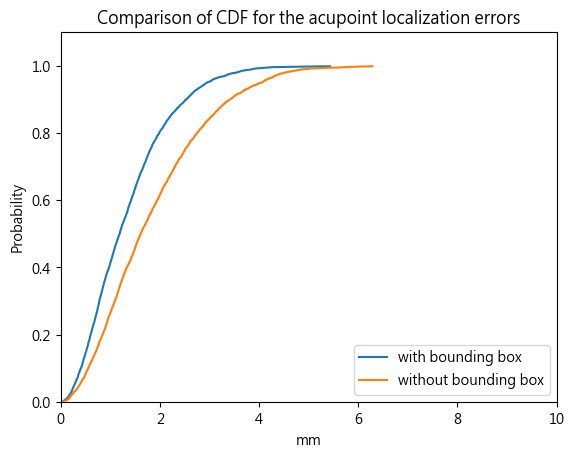

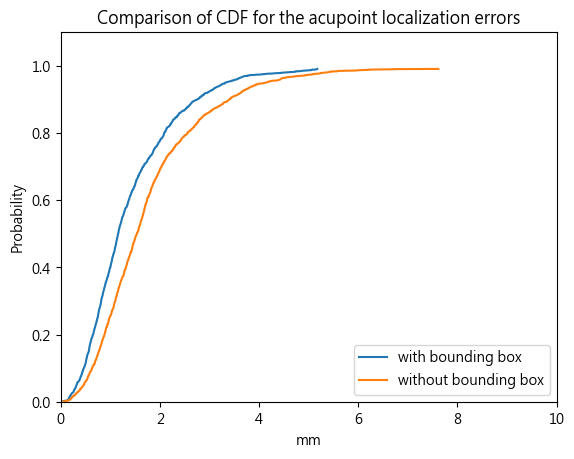

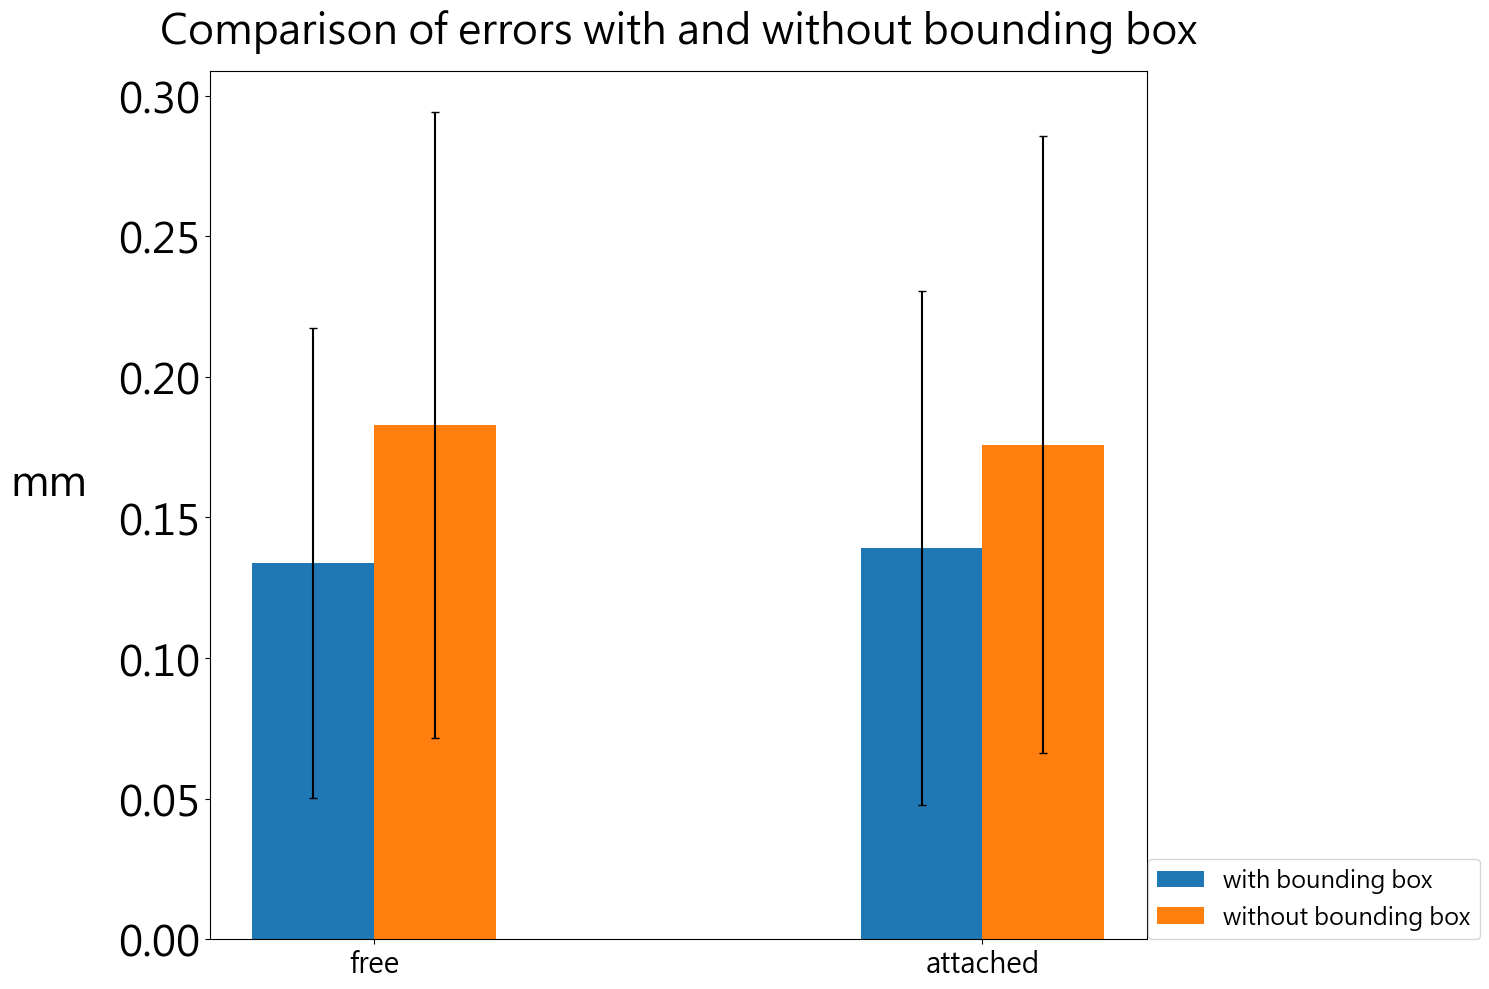

In [30]:
if __name__ == '__main__':
    A = errors("MAT_inpainting")
    B = errors("without_bbox")
    wrapped_errors_A = A.wrap_err_from_csv()
    wrapped_errors_B = B.wrap_err_from_csv()
    C = plot_fig([wrapped_errors_A, wrapped_errors_B])
#     D = plot_fig(wrapped_errors_B)

    C.CDF_fig("Comparison of CDF for the acupoint localization errors", ["with bounding box", "without bounding box"])
    C.bar_fig_total("Comparison of errors with and without bounding box", ["with bounding box", "without bounding box"])

In [4]:
class localization_error_Draw():
    def __init__(self):
        self.ear_types = ["free","attached"]
        self.occluded_result = "../occluded_result"
        self.degrees = ['15cm_0mm_0deg', '15cm_25mm_5deg', '15cm_50mm_10deg',
                        '20cm_0mm_0deg', '20cm_25mm_5deg', '20cm_50mm_10deg']
        self.acupoints_name = ["HX6(肛門)", "HX3(尿道)", "HX1(耳中)", "TF4(神門)", "AH9(腰柢椎)", "AH11(胸椎)", "CO5(十二指腸)", 
                               "CO4(胃)", "CO3(賁門)", "CO14(肺)", "CO15(心)", "CO18(內分泌)", "HX2(輪2)", "AT2(緣中)", 
                               "LO8(扁桃體)", "LO1(牙)" , "LO2(舌)", "LO3(頷)", "LO4(垂前)", "LO5(眼)", "LO6(內耳)"]
        self.cm = {"cather":4.72, "daniel":4.74, "dominic":3.9, "jack":3.91, "jakaria":4.20, "jimmy":4.60, "vicky":4.69, "wayne":4.75,
                   "gaby":4.05, "matt":5.0, "toby":4.26, "wendy":4.14, "willy":4.51}
        
    def read_csv(self, fpath1):
        df = pd.read_csv(fpath1, index_col = 0)
        return df

    def all_error(self):
        result = {}
        for ear_type in self.ear_types:
            result[ear_type] = {}
            names = os.listdir(os.path.join(self.occluded_result, ear_type))
            for name in names:
                result[ear_type][name] = {}
                for deg in self.degrees:
                    result[ear_type][name][deg] = []
                    indexes = os.listdir(os.path.join(self.occluded_result, ear_type, name, "error", deg))
                    for index in indexes:
                        error_np = self.read_csv(os.path.join(self.occluded_result, ear_type, name, "error", deg, index, "error.csv")).to_numpy()
                        result[ear_type][name][deg].append(error_np)
        return result

    def draw_each_acu_bars(self, title, all_error):
        for ear_type in self.ear_types:
            names = os.listdir(os.path.join(self.occluded_result, ear_type))
            for deg in self.degrees:
                plt.figure(figsize=(15,10))
                for i in range(4):
                    a = np.zeros(shape=(1,all_error[ear_type][names[0]][deg][i].shape[1]))
                    for name in names:
                        a = np.concatenate((a, all_error[ear_type][name][deg][i]), axis = 0)
                    mean = np.nanmean(a, axis = 0)*10
                    std = np.nanstd(a, axis = 0)*10
#                     mins = np.nanmin(a, axis = 0)*10
#                     maxs = np.nanmax(a, axis = 0)*10
        
                    plt.bar(np.arange(len(mean)) + i*0.2, mean, yerr=std, align='center', label = '{index} degrees'.format(index = 0 + 10*i), ecolor='black', capsize=3, width=0.2)
#                     plt.bar(np.arange(len(mean)) + i*0.2, mean, yerr=[mean-mins, maxs-mean], align='center', label = '{index} degrees'.format(index = 0 + 10*i), ecolor='black', capsize=3, width=0.2)
                plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

                plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

                font_path = r'C:\Windows\Fonts\msjhl.ttc'
                font = FontProperties(fname=font_path, size=12)
                plt.xticks(np.arange(all_error[ear_type][names[0]][deg][i].shape[1]) + 0.3, self.acupoints_name[:all_error[ear_type][names[0]][deg][i].shape[1]], fontsize=12, rotation=-45, ha='center')

                plt.yticks(fontsize=30)
                plt.title(title, fontsize = 30, pad = 20)

                plt.legend(fontsize=17, ncol = 2, frameon = True)
                plt.ylim(0, 6)
                plt.tight_layout()
#                 if not os.path.isdir(os.path.join("..", "figure", "occlusion")):
#                     os.makedirs(os.path.join("..", "figure", "occlusion"))
#                 plt.savefig(os.path.join("..", "figure", "occlusion",'total_average.png').format(index = 0))
                plt.show()
    def draw_each_subject_bars(self, title, all_error):
        for ear_type in self.ear_types:
            names = os.listdir(os.path.join(self.occluded_result, ear_type))
            for deg in self.degrees:
                plt.figure(figsize=(15,10))
                for i in range(4):
                    means = []
                    stds = []
                    mins = []
                    maxs = []
                    for name in names:
                        means.append(np.nanmean(all_error[ear_type][name][deg][i]*10, axis = (0, 1)))
                        stds.append(np.nanstd(all_error[ear_type][name][deg][i]*10, axis = (0, 1)))
#                         mins.append(np.nanmin(all_error[ear_type][name][deg][i])*10)
#                         maxs.append(np.nanmax(all_error[ear_type][name][deg][i])*10)
                    maxs = np.array(maxs)
                    mins = np.array(mins)
                    plt.bar(np.arange(len(means)) + i*0.2, means, yerr=stds, align='center', label = '{index} degrees'.format(index = 0 + 10*i), ecolor='black', capsize=3, width=0.2)
#                     plt.bar(np.arange(len(means)) + i*0.2, means, yerr=[means-mins, maxs-means], align='center', label = '{index} degrees'.format(index = 0 + 10*i), ecolor='black', capsize=3, width=0.2)
                plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

                plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

                font_path = r'C:\Windows\Fonts\msjhl.ttc'
                font = FontProperties(fname=font_path, size=12)
                plt.xticks(np.arange(len(names)) + 0.3, ["Subject"+str(x) for x in list(range(len(means)))], fontsize=12, rotation=-45, ha='center')

                plt.yticks(fontsize=30)
                plt.title(title, fontsize = 30, pad = 20)
                plt.ylim(0, 6)
#                 plt.legend(fontsize=17, ncol = 1)
                plt.legend(fontsize=17, ncol = 2, frameon = True)
                plt.tight_layout()
        #                 if not os.path.isdir(os.path.join("..", "figure", "occlusion")):
        #                     os.makedirs(os.path.join("..", "figure", "occlusion"))
        #                 plt.savefig(os.path.join("..", "figure", "occlusion",'total_average.png').format(index = 0))
                plt.show()
    def draw_total_bars(self, title, total_err):
        plt.figure(figsize=(15,10))
        
        means = []
        stds = []
        for ear_type in self.ear_types:
            means.append(np.nanmean(total_err[ear_type], axis = (0,1))*10)
            stds.append(np.nanstd(total_err[ear_type], axis = (0,1))*10)
        print(means)
        print(stds)

        plt.bar(np.arange(len(self.ear_types)), means, yerr=stds, align='center', label = ear_type, ecolor='black', capsize=3, width=0.2)

        plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

        plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

        font_path = r'C:\Windows\Fonts\msjhl.ttc'
        font = FontProperties(fname=font_path, size=12)
        plt.xticks(np.arange(len(self.ear_types)), self.ear_types, fontsize=12, rotation=-45, ha='center')


        plt.yticks(fontsize=30)
        plt.title(title, fontsize = 30, pad = 20)

#         plt.legend(fontsize=17, ncol = 2)

        plt.tight_layout()

#         if not os.path.isdir(os.path.join("..", "figure", "occlusion")):
#             os.makedirs(os.path.join("..", "figure", "occlusion"))
#         plt.savefig(os.path.join("..", "figure", "occlusion",'total_average.png').format(index = 0))

        plt.show()

                

In [32]:
B = localization_error_Draw()
occlu = B.all_error()
A = errors("MAT_inpainting")
wrapped_errors_A = A.wrap_err_from_csv()

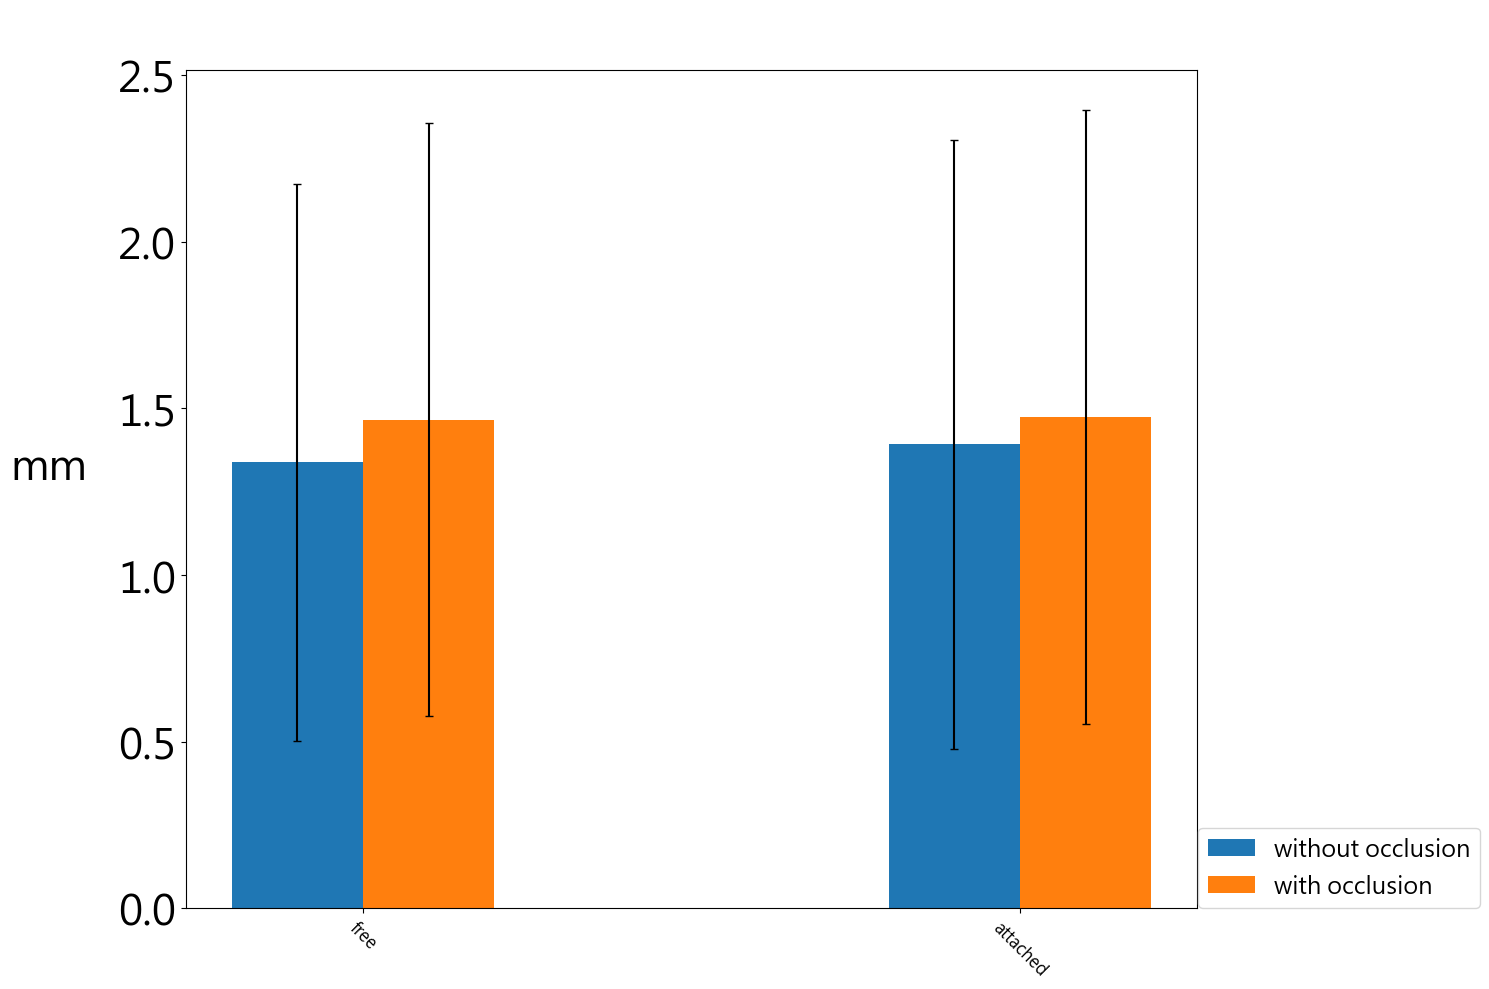

In [45]:


# wrapped_errors = [occlu, wrapped_errors_A]
wrapped_errors = [wrapped_errors_A, occlu]

# labels = ["with occlusion","without occlusion"]
labels = ["without occlusion","with occlusion"]
plt.figure(figsize=(15,10))
for j in range(0, len(wrapped_errors)):    
    means = []
    stds = []
    if j == 0:
        for ear_type in ear_types:
            means.append(np.nanmean(wrapped_errors[j][ear_type], axis = (0, 1, 2, 3))*10)
            stds.append(np.nanstd(wrapped_errors[j][ear_type], axis = (0, 1, 2, 3))*10)
    else:
        for ear_type in ear_types:
            names = os.listdir(os.path.join("../occluded_result", ear_type))
            a = np.zeros(shape=(1,wrapped_errors[j][ear_type][names[0]]["15cm_0mm_0deg"][0].shape[1]))
            for deg in degrees:            
                for i in range(4):
                    for name in names:
                        a = np.concatenate((a, wrapped_errors[j][ear_type][name][deg][i]), axis = 0)
#                         means.append(np.nanmean(wrapped_errors[j][ear_type][name][deg][i], axis = (0, 1)))
#                         stds.append(np.nanstd(wrapped_errors[j][ear_type][name][deg][i], axis = (0, 1)))

        
            means.append(np.nanmean(a, axis = (0,1))*10)
            stds.append(np.nanstd(a, axis = (0,1))*10)
  
    plt.bar(np.arange(len(ear_types))+j*0.2, means, yerr=stds, align='center', label = labels[j], ecolor='black', capsize=3, width=0.2)

plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

font_path = r'C:\Windows\Fonts\msjhl.ttc'
font = FontProperties(fname=font_path, size=12)
plt.xticks(np.arange(len(ear_types))+ 0.1, ear_types, fontsize=12, rotation=-45, ha='center')


plt.yticks(fontsize=30)
plt.title(" ", fontsize = 30, pad = 20)
plt.legend(fontsize=17, ncol = 1, loc = (1.001, 0))


plt.tight_layout()



plt.show()
